# Importing Libraries

In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                          Dense, Flatten, Dropout)
from keras.optimizers import RMSprop, Adam, SGD
from keras import regularizers
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau

In [5]:
tf.keras.backend.clear_session() #clean session

In [6]:
main_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

train_dir = os.path.join(main_path, 'train')
valid_dir = os.path.join(main_path, 'valid')
test_dir = os.path.join(main_path, 'test')

In [7]:
print("Train_dir Subfolders: ", os.listdir(train_dir))
print("Valid_dir Subfolders: ", os.listdir(valid_dir))
print("Test_dir Subfolders: ", os.listdir(test_dir))

Train_dir Subfolders:  ['fake', 'real']
Valid_dir Subfolders:  ['fake', 'real']
Test_dir Subfolders:  ['fake', 'real']


In [8]:
import glob
images_df = {
    "folder":[],
    "image_path":[],
    "label":[]
}

for folder in os.listdir(main_path): #iterate on each train, valid and test folder
    for label in os.listdir(main_path + "/" + folder): #iterate on fake and real folders (labels)
        for img in glob.glob(main_path + "/" + folder + "/" + label + "/*.jpg"):
            images_df["folder"].append(folder)
            images_df["image_path"].append(img)
            images_df["label"].append(label)

In [9]:
images_df = pd.DataFrame(images_df)

In [10]:
df=images_df

In [11]:
import pandas as pd

valid_fake_count = 5000*2
valid_real_count = 5000*2

train_fake_count = 25000*2
train_real_count = 25000*2

test_fake_count = 5000*2
test_real_count = 5000*2

# Filter the DataFrame for each folder and image type
valid_df = df[(df['folder'] == 'valid') & (df['label'] == 'fake')][:valid_fake_count]
valid_df = pd.concat([valid_df, df[(df['folder'] == 'valid') & (df['label'] == 'real')][:valid_real_count]])

train_df = df[(df['folder'] == 'train') & (df['label'] == 'fake')][:train_fake_count]
train_df = pd.concat([train_df, df[(df['folder'] == 'train') & (df['label'] == 'real')][:train_real_count]])

test_df = df[(df['folder'] == 'test') & (df['label'] == 'fake')][:test_fake_count]
test_df = pd.concat([test_df, df[(df['folder'] == 'test') & (df['label'] == 'real')][:test_real_count]])

# Combine the DataFrames into a new one
new_df = pd.concat([valid_df, train_df, test_df])

# Reset the index
new_df.reset_index(drop=True, inplace=True)

# Display the new DataFrame



In [12]:
new_df["label"].value_counts()

label
fake    70000
real    70000
Name: count, dtype: int64

# Train and Validation Set 

In [13]:
# Define the path to the directory containing your dataset
# (This assumes your 'image_path' column contains the full paths to the images)
path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'

# Extract relevant image paths from the 'image_path' column
image_paths = new_df['image_path'].tolist()

bs = 64
row, col = 224, 224

# Training set generator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
training_set = train_datagen.flow_from_dataframe(dataframe=new_df[new_df['folder'] == 'train'],
                                                 directory=path,
                                                 x_col="image_path",
                                                 y_col="label",
                                                 class_mode="binary",
                                                 target_size=(row, col),
                                                 batch_size=bs,
                                                 shuffle=True
                                                )

# Validation set generator
val_test_datagen = ImageDataGenerator(rescale=1./255)
validation_set = val_test_datagen.flow_from_dataframe(dataframe=new_df[new_df['folder'] == 'valid'],
                                                      directory=path,
                                                      x_col="image_path",
                                                      y_col="label",
                                                      class_mode="binary",
                                                      target_size=(row, col),
                                                      batch_size=bs,
                                                      shuffle=True
                                                     )

# Test set generator
test_set = val_test_datagen.flow_from_dataframe(dataframe=new_df[new_df['folder'] == 'test'],
                                                directory=path,
                                                x_col="image_path",
                                                y_col="label",
                                                class_mode="binary",
                                                target_size=(row, col),
                                                batch_size=bs,
                                                shuffle=True
                                               )

# Display class indices
print(training_set.class_indices)


Found 100000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
Found 20000 validated image filenames belonging to 2 classes.
{'fake': 0, 'real': 1}


In [14]:
from tensorflow.keras.applications import DenseNet121
def get_model():
    densenet = DenseNet121(weights='imagenet',
                           include_top=False,
                           input_shape=(224,224,3)
                          )
    model = tf.keras.models.Sequential([densenet,
                                        GlobalAveragePooling2D(),
                                        Dense(512, activation='relu'),
                                        BatchNormalization(),
                                        Dropout(0.3),
                                        Dense(1, activation='sigmoid')
                                      ])
    model.compile(optimizer=Adam(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']
                )

    return model

spoofnet = get_model()
spoofnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

### Defining Model Checkpoints

In [15]:
checkpoint = ModelCheckpoint(filepath='spoffnet.h5',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [25]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

hist = spoofnet.fit(training_set,
                    validation_data=validation_set,
                    callbacks=callbacks,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps,
                    epochs=5
                   )

Epoch 1/5
1562/1562 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9969
Epoch 1: val_loss improved from 0.31578 to 0.01873, saving model to spoffnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1562/1562 [==============================] - 606s 388ms/step - loss: 0.0095 - accuracy: 0.9969 - val_loss: 0.0187 - val_accuracy: 0.9937 - lr: 2.0000e-04
Epoch 2/5
1562/1562 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9986
Epoch 2: val_loss did not improve from 0.01873
1562/1562 [==============================] - 604s 386ms/step - loss: 0.0041 - accuracy: 0.9986 - val_loss: 0.0348 - val_accuracy: 0.9894 - lr: 2.0000e-04
Epoch 3/5
1562/1562 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9987
Epoch 3: val_loss improved from 0.01873 to 0.01756, saving model to spoffnet.h5
1562/1562 [==============================] - 614s 393ms/step - loss: 0.0036 - accuracy: 0.9987 - val_loss: 0.0176 - val_accuracy: 0.9943 - lr: 2.0000e-04
Epoch 4/5
1562/1562 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9988
Epoch 4: val_loss did not improve from 0.01756
1562/1562 [==============================] - 608s 389ms/step - loss: 0.00

# plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

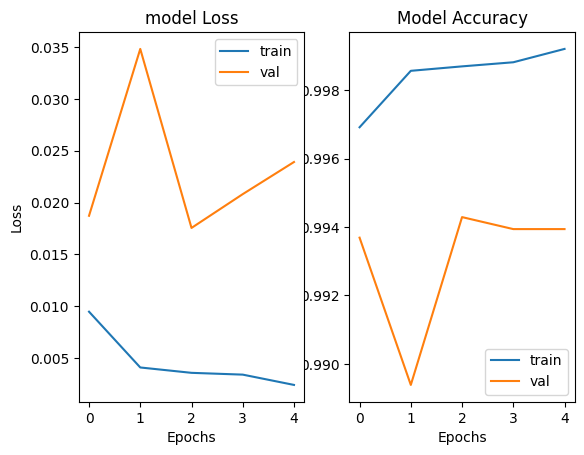

In [28]:
# plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

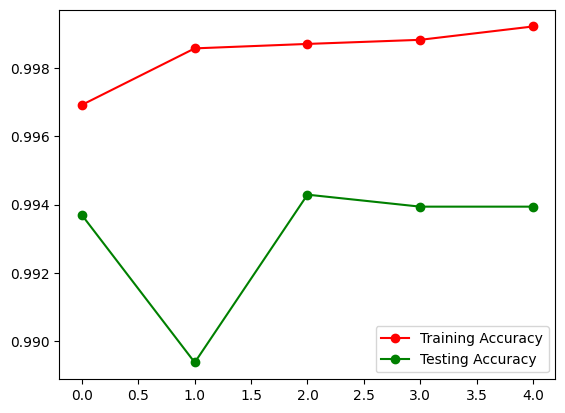

In [29]:
plt.plot(hist.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(hist.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()


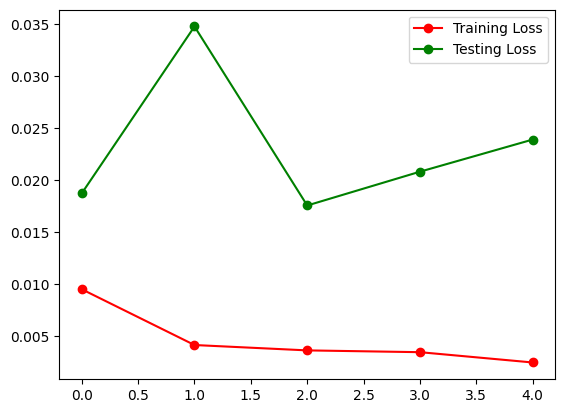

In [30]:
plt.plot(hist.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(hist.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

# Accuracy On test set

In [31]:
_, accu = spoofnet.evaluate(test_set)
print('Final Test Acccuracy = {:.3f}'.format(accu*100))

313/313 [==============================] - 83s 265ms/step - loss: 0.0200 - accuracy: 0.9943
Final Test Acccuracy = 99.430


# Confusion Matrix and Classification Report

313/313 [==============================] - 66s 210ms/step
Confusion Matrix
[[9511  489]
 [ 501 9499]]


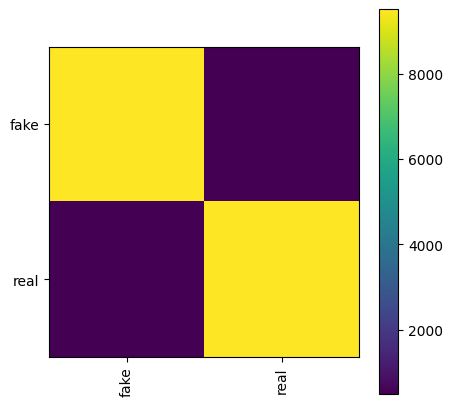

In [35]:
y_pred = spoofnet.predict(validation_set)
y_pred = (y_pred < 0.5).astype(int)

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm)

names = ['fake', 'real']


plt.figure(figsize=(5,5))
plt.imshow(cm)
plt.colorbar()
tick_mark = np.arange(len(names))
_ = plt.xticks(tick_mark, names, rotation=90)
_ = plt.yticks(tick_mark, names)

<Axes: >

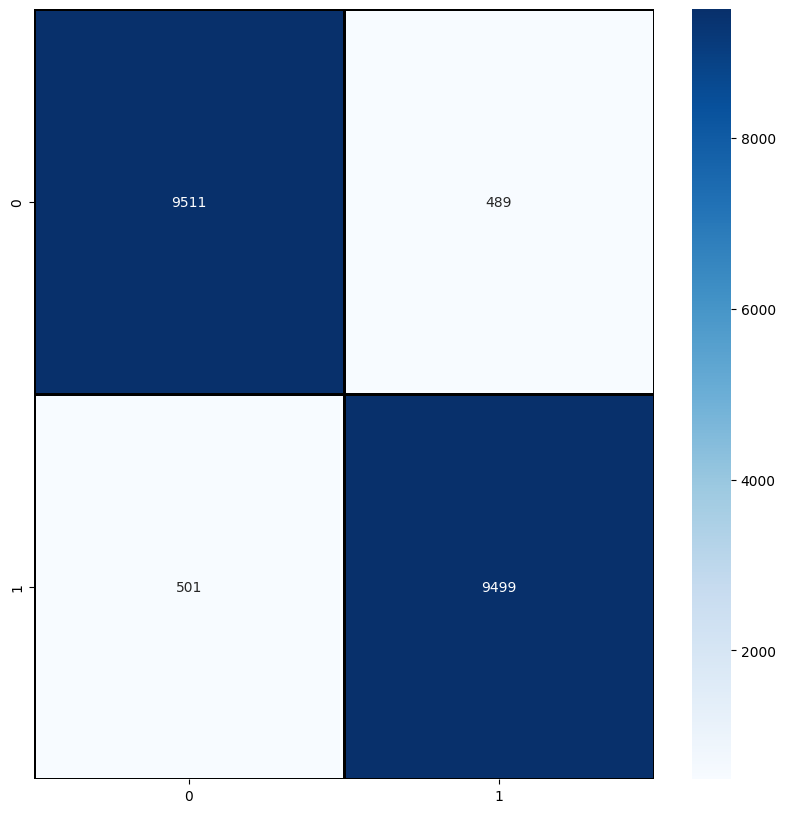

In [36]:
#cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
import seaborn as sns
cm = pd.DataFrame(cm , index = [i for i in range(2)] , columns = [i for i in range(2)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

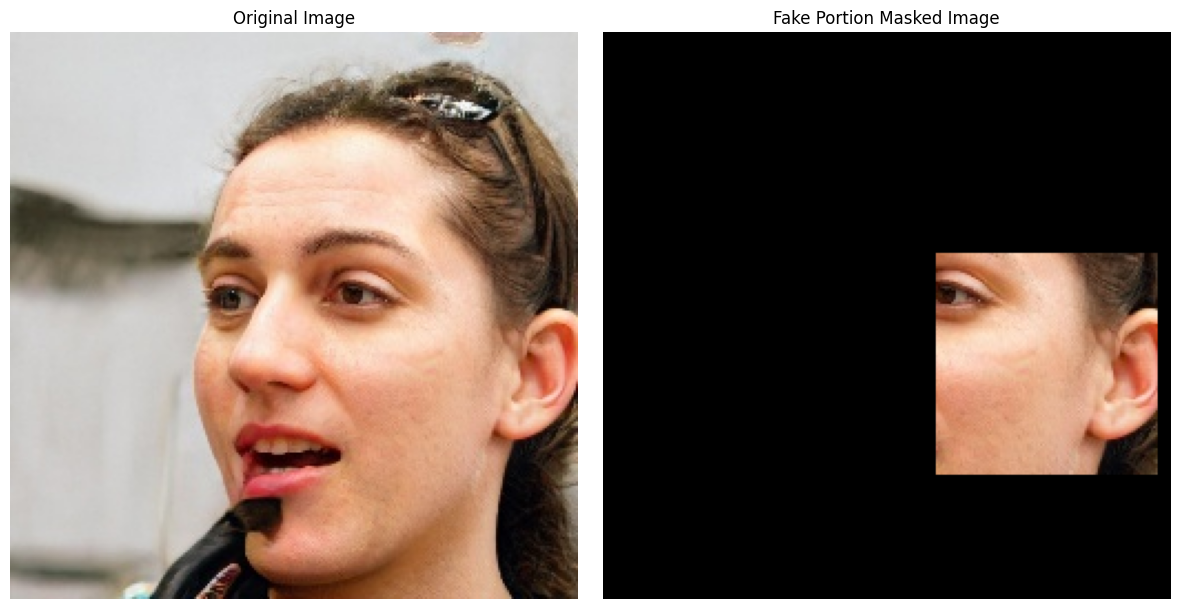

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image (replace 'entire_image.jpg' with your image file)
image = cv2.imread('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00F8LKY6JC.jpg')

# Create a binary mask (replace these with your specific criteria)
fake_face_mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
fake_face_mask[100:200, 150:250] = 255  # Example: a rectangle region as fake face

# Apply the mask to the original image
masked_image = cv2.bitwise_and(image, image, mask=fake_face_mask)

# Display the original image and the masked image using Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot masked image
axes[1].imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Fake Portion Masked Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()


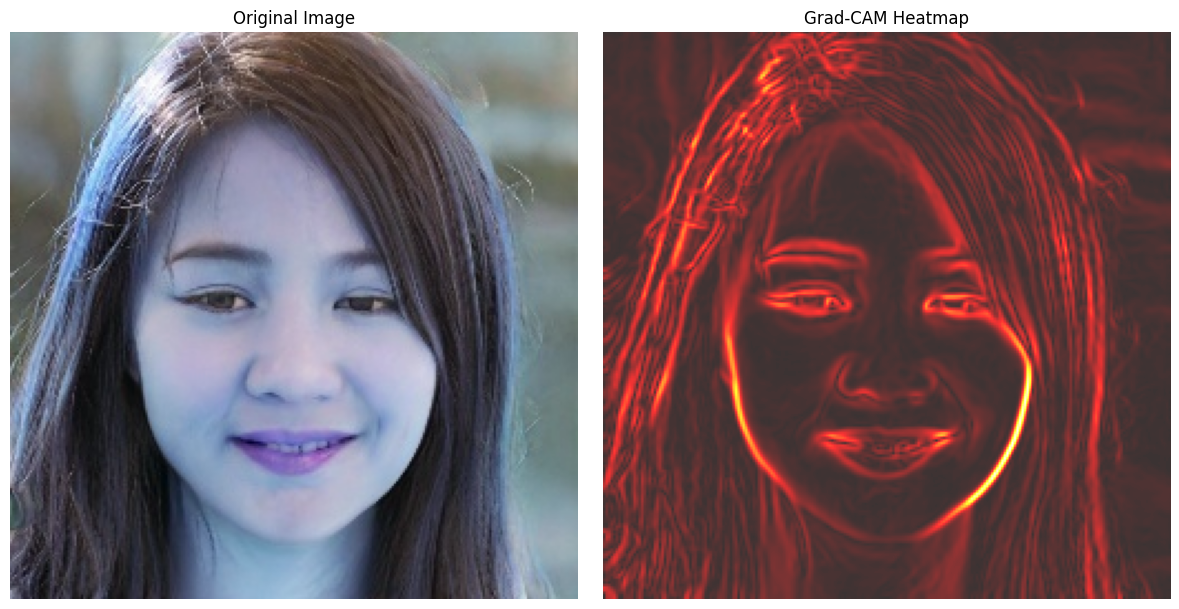

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def grad_cam(img_path):
    # Load the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))  # Resize to match input size of most pre-trained models

    # Convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Compute gradient magnitude
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalize gradient magnitude to range [0, 1]
    gradient_magnitude /= gradient_magnitude.max()

    return gradient_magnitude

# Path to the image
img_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00276TOPP4.jpg'  # Replace with your image file


# Compute Grad-CAM
heatmap = grad_cam(img_path)

# Plot the original image and the Grad-CAM heatmap
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot original image
axes[0].imshow(cv2.imread(img_path))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Plot Grad-CAM heatmap
axes[1].imshow(heatmap, cmap='hot', alpha=0.8)
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

plt.tight_layout()
plt.show()


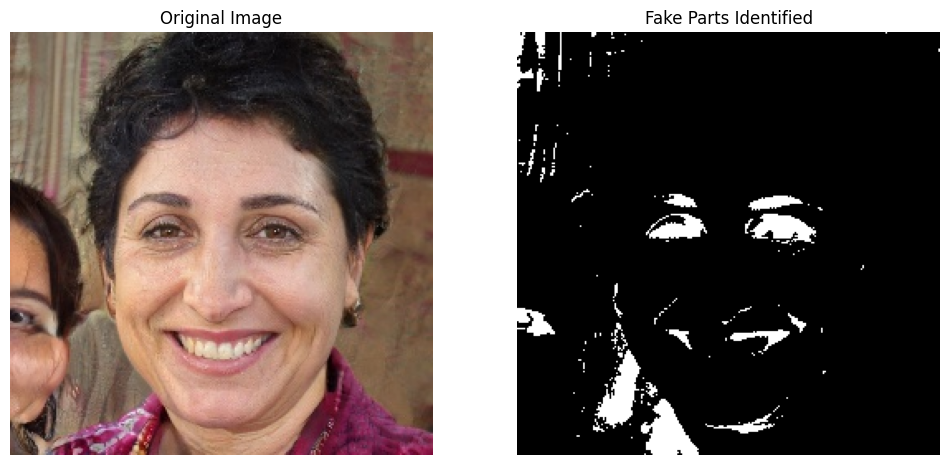

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image = cv2.imread('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake/00QKZTHTLF.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to binarize the image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the binary image to get black background and white foreground
binary = cv2.bitwise_not(binary)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the fake parts of the image
fake_mask = np.zeros_like(binary)

# Iterate through each contour
for contour in contours:
    # Compute the area of the contour
    area = cv2.contourArea(contour)
    # If the area is below a certain threshold, consider it as fake
    if area < 1000:  # Adjust this threshold according to your image
        # Draw the contour on the mask
        cv2.drawContours(fake_mask, [contour], -1, (255), thickness=cv2.FILLED)

# Plot the original image and the identified fake parts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_mask, cmap='gray')
plt.title('Fake Parts Identified')
plt.axis('off')

plt.show()


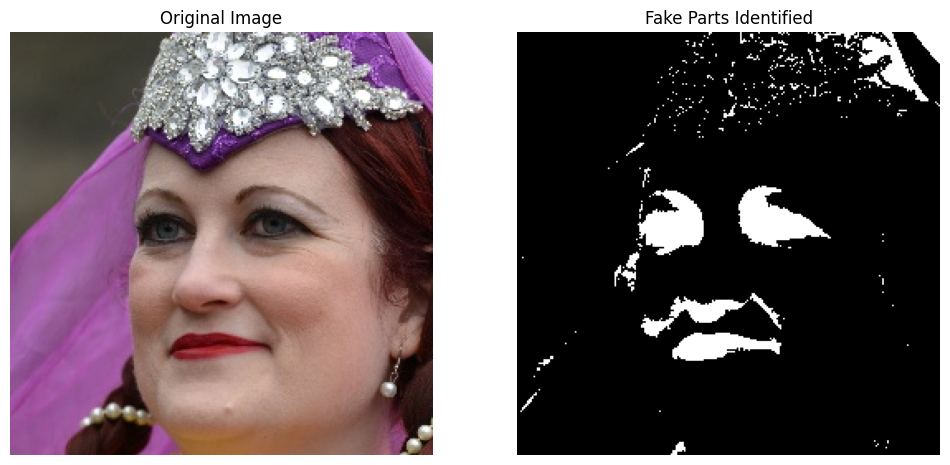

In [50]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
image = cv2.imread('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real/00170.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply adaptive thresholding to binarize the image
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Invert the binary image to get black background and white foreground
binary = cv2.bitwise_not(binary)

# Find contours in the binary image
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a mask for the fake parts of the image
fake_mask = np.zeros_like(binary)

# Iterate through each contour
for contour in contours:
    # Compute the area of the contour
    area = cv2.contourArea(contour)
    # If the area is below a certain threshold, consider it as fake
    if area < 1000:  # Adjust this threshold according to your image
        # Draw the contour on the mask
        cv2.drawContours(fake_mask, [contour], -1, (255), thickness=cv2.FILLED)

# Plot the original image and the identified fake parts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(fake_mask, cmap='gray')
plt.title('Fake Parts Identified')
plt.axis('off')

plt.show()
